# Dashcam Car Detection Model

### Purpose:

A live video feed showing detected cars.
This can be used in a dashcam type setup for object tracking purposes. The model can differeniate between 5 different vehicle types ('Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck').

### Expansion:

My ultmate goal at the end of the model is to take the converting TFlite or TFJS and implement it into an app making is more ideal for a real use-case.

### Credits:

Some of the pipeline is dependent on Nicholas Renotte's tutorial (https://www.youtube.com/watch?v=yqkISICHH-U) and repo (https://github.com/nicknochnack/TFODCourse). The verification script is by him as well as a few coding blocks which take into account different operating systems. 

For this project I took an existing set of TFrecords based on this roboflow dataset (https://universe.roboflow.com/gaurigodghase-gmail-com/vehicles-openimages-svzce/dataset/1)

## 1. Packages and Dependencies

** NOTE: We may need to import/get some repos and packages later on as well

#### Packages and imports for image capture

In [ ]:
!pip install opencv-python
!pip install --upgrade pyqt5 lxml

import cv2 
import uuid # To create unique ID's for captured image files
import os # Check's which operating system is being used
import time # To create time gaps between each image capture

#### Packages and imports for training, testing and demo

In [ ]:
# Windows only need to get wget
if os.name=='nt':
    !pip install wget
    import wget

# Veriffication Script missing packages
!pip install tensorflow --upgrade
!pip install scipy
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2
!pip install protobuf==3.20.*
!pip install pillow
!pip install pyyaml
!pip install wheel
!pip install pandas

# Neccessary imports for training
import object_detection
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Neccessary imports for demo / visualization
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 2. Dataset preperation

#### Setup labels and folder structures and paths

In [ ]:
labels = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
number_imgs = 5

In [ ]:
IMAGES_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'collectedimages')

In [ ]:
if not os.path.exists(IMAGES_PATH):
    if os.name == 'posix':
        !mkdir -p {IMAGES_PATH}
    if os.name == 'nt':
         !mkdir {IMAGES_PATH}
for label in labels:
    path = os.path.join(IMAGES_PATH, label)
    if not os.path.exists(path):
        !mkdir {path}

## 3. Training Setup

In [4]:
# Set up all the neccessary variables for the model, paths, and files for later covenience
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
# Create the various paths above
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [6]:
# Fetch the model
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
# Verification script checking to make sure all neccessary packages are installed
# Should read 'ok' at the end
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

In [ ]:
# Setup with pre-trained model
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

In [ ]:
# Fetch TF records script
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
# Creates TFRecords based of the XML and JPG files from the train image set
# TFRecords essentailly is a readable file for the model when being trained
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

In [ ]:
# Copt the pipeline.config file
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [ ]:
# View the config file which initally will have blanks which need to be filed with various paths
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

In [ ]:
# Fill config file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  
    
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)  

In [ ]:
# Get training script 
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

## 4. Training

In [ ]:
# Change '--num_train_steps=X' to however many steps desired
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

In [ ]:
# You can choose to run the command within 
# the notebook or copy it from above and run it in the terminal
# For acceleratd GPU performance with CUDA make sure you pip install tensorflow-gpu
!{command}

## 5. Evaluation

In [ ]:
# Run this command within the terminal to get loss metrics and more
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

In [ ]:
# ALETRNATIVE use tensorboard
# navigate to Tensorflow/workspace/models/my_ssd_mobnet/[train and eval]
# Once you run the command go to the localhost url
command = "python -m tensorboard.main --logdir=."
print(command)

## 8. Access trained model for demo

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## 9. Images demo

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [10]:
# Declare paths for various test images 
IMAGE_PATH_0 = os.path.join(paths['IMAGE_PATH'], 'test', 'e4029e591e9568b4_jpg.rf.09649e5b4e074f8d2a8d46553fa13e76.jpg')

In [11]:
tf.config.run_functions_eagerly(True)

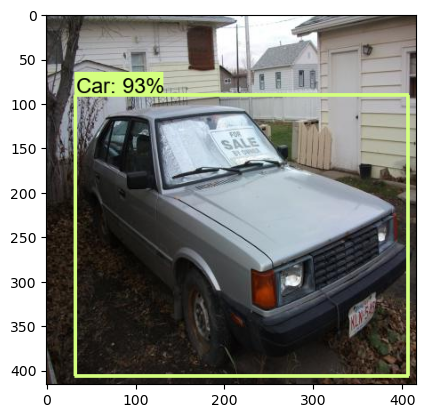

In [12]:
# Grab one of the images and run it through with the model to then see the output
img = cv2.imread(IMAGE_PATH_0)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

## 10. Live Video demo

In [ ]:
# This craetes a live video feed with the model running
# Press 'q' to stop video
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

#### Demo avaliable at: 



## 9. Freeze Graph for Export

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])
!{command}

## 11. Model Conversions

#### Convert to TFJS

In [ ]:
!pip install tensorflowjs
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])
!{command}

#### Convert to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )
!{command}

## 12. Conclusion

This is the full pipeline of teh Sign Language Detection model, with the ocnversion to different formats compleet we can now take this project and implement it within a existing application.